In [1]:
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.data_utils import rank_genes_groups

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.model_selection import train_test_split

/home/ubuntu/anaconda3/envs/dpi-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We load the single-cell data using scanpy. The single-cell data is stored in a special data structure called AnnData (short: adata).

In [2]:
adata = sc.read('marson_formatted_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 56081 × 17344
    obs: 'barcode', 'nCount_RNA', 'cluser_name', 'celltype', 'donor', 'stim', 'totally_qualified', 'unabiguous_sgRNA', 'sgRNA', 'ntc', 'target', 'stim_celltype'
    var: 'ENSGNM', 'name', 'is_sgRNA'

The counts are stored in adata.X


In [3]:
adata.X 

<56081x17344 sparse matrix of type '<class 'numpy.float32'>'
	with 146404662 stored elements in Compressed Sparse Row format>

In [4]:
adata.X.max() #check it's an int, to make sure it's count data and not preprocessed data

2312.0

adata.obs is a dataframe containing annotation for each cell, such as e.g. batch, cell type, perturbation. Or other technical annotations at the cell level. \
adata.var is a dataframe containing annotation for each gene, usually some statistics such as dispersion, or gene names, pathways etc.

In [5]:
adata.obs

,barcode,nCount_RNA,cluser_name,celltype,donor,stim,totally_qualified,unabiguous_sgRNA,sgRNA,ntc,target,stim_celltype
0,AAACCCACAACAAGAT-1,3650.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,PLCG2-2,False,PLCG2,resting_cd8
1,AAACCCACAACGGCTC-1,0.0,,,,,False,True,HELZ2-1,False,HELZ2,_
3,AAACCCACACCCTGTT-1,9719.0,10: Proliferating (S,CD4,Donor1,Resting,True,True,OTUD7B-1,False,OTUD7B,resting_cd4
4,AAACCCACACTATGTG-1,4043.0,6: CD4 Common,Unassigned,Donor2,Resting,False,True,CD247-1,False,CD247,resting_unassigned
6,AAACCCAGTATGAGAT-1,3222.0,6: CD4 Common,Unassigned,Donor1,Resting,False,True,IL2RB-2,False,IL2RB,resting_unassigned
...,...,...,...,...,...,...,...,...,...,...,...,...
103796,TTTGTTGCACAGCCAC-8,11612.0,14: CD4 Common,Unassigned,Donor2,Re-stimulated,False,True,TNFRSF12A-2,False,TNFRSF12A,restimulated_unassigned
103797,TTTGTTGCACTATGTG-8,4278.0,14: CD4 Common,CD4,Donor1,Re-stimulated,True,True,LHX6-2,False,LHX6,restimulated_cd4
103798,TTTGTTGCACTCAGAT-8,4369.0,1: IFNG High 1,Unassigned,Donor1,Re-stimulated,False,True,TBX21-2,False,TBX21,restimulated_unassigned
103799,TTTGTTGCAGTCAGTT-8,2824.0,7: TNF Locus High,Unassigned,Donor1,Re-stimulated,False,True,TRIM21-2,False,TRIM21,restimulated_unassigned


In [6]:
adata.obs.rename(columns={'cluser_name':'cluster_name'}, inplace=True)

In [7]:
adata = adata[adata.obs['nCount_RNA'] > 0]

In [8]:
adata.obs.groupby('donor').size()

donor
Donor1        28655
Donor2        24298
Unassigned        2
dtype: int64

In [9]:
adata = adata[adata.obs['donor'] != 'Unassigned']

In [10]:
adata.obs

,barcode,nCount_RNA,cluster_name,celltype,donor,stim,totally_qualified,unabiguous_sgRNA,sgRNA,ntc,target,stim_celltype
0,AAACCCACAACAAGAT-1,3650.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,PLCG2-2,False,PLCG2,resting_cd8
3,AAACCCACACCCTGTT-1,9719.0,10: Proliferating (S,CD4,Donor1,Resting,True,True,OTUD7B-1,False,OTUD7B,resting_cd4
4,AAACCCACACTATGTG-1,4043.0,6: CD4 Common,Unassigned,Donor2,Resting,False,True,CD247-1,False,CD247,resting_unassigned
6,AAACCCAGTATGAGAT-1,3222.0,6: CD4 Common,Unassigned,Donor1,Resting,False,True,IL2RB-2,False,IL2RB,resting_unassigned
9,AAACCCATCTACCTTA-1,4602.0,8: CD8 Common,CD8,Donor2,Resting,True,True,PLCG2-2,False,PLCG2,resting_cd8
...,...,...,...,...,...,...,...,...,...,...,...,...
103796,TTTGTTGCACAGCCAC-8,11612.0,14: CD4 Common,Unassigned,Donor2,Re-stimulated,False,True,TNFRSF12A-2,False,TNFRSF12A,restimulated_unassigned
103797,TTTGTTGCACTATGTG-8,4278.0,14: CD4 Common,CD4,Donor1,Re-stimulated,True,True,LHX6-2,False,LHX6,restimulated_cd4
103798,TTTGTTGCACTCAGAT-8,4369.0,1: IFNG High 1,Unassigned,Donor1,Re-stimulated,False,True,TBX21-2,False,TBX21,restimulated_unassigned
103799,TTTGTTGCAGTCAGTT-8,2824.0,7: TNF Locus High,Unassigned,Donor1,Re-stimulated,False,True,TRIM21-2,False,TRIM21,restimulated_unassigned


In [11]:
idx = None
for col in adata.obs.columns[[*range(2,7)]]:
    if col == 'totally_qualified':
        idx = idx & (adata.obs[col]==True).to_numpy()
        continue
    if idx is None:
        idx = (adata.obs[col]==adata.obs[col][0]).to_numpy()
    else:
        idx = idx & (adata.obs[col]==adata.obs[col][0]).to_numpy()
idx = idx & (adata.obs['ntc']==True).to_numpy()

adata.obs[idx]

,barcode,nCount_RNA,cluster_name,celltype,donor,stim,totally_qualified,unabiguous_sgRNA,sgRNA,ntc,target,stim_celltype
21,AAACGAACAGTCGGTC-1,3241.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-7,True,NTC,resting_cd8
1765,AGCCACGAGCACACCC-1,6171.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-3,True,NTC,resting_cd8
1981,AGGATCTCATGGAACG-1,11898.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-4,True,NTC,resting_cd8
2932,ATGGAGGGTGTACATC-1,4434.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-1,True,NTC,resting_cd8
4737,CCTAAGATCAGACCGC-1,4668.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-7,True,NTC,resting_cd8
5809,CTCATCGAGTATAGAC-1,6855.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-5,True,NTC,resting_cd8
9719,TAACCAGTCATTTCGT-1,5446.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-2,True,NTC,resting_cd8
9921,TACCGAAAGGTAGCCA-1,8976.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-8,True,NTC,resting_cd8
11469,TCTCAGCCAGGGACTA-1,906.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-8,True,NTC,resting_cd8
12673,TTACCGCGTAGTGCGA-1,6611.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,NO-TARGET-4,True,NTC,resting_cd8


In [12]:
adata.var

,ENSGNM,name,is_sgRNA
3,ENSG00000238009,AL627309.1,False
6,ENSG00000241860,AL627309.5,False
14,ENSG00000237491,LINC01409,False
16,ENSG00000228794,LINC01128,False
17,ENSG00000225880,LINC00115,False
...,...,...,...
36579,ENSG00000278384,AL354822.1,False
36580,ENSG00000273748,AL592183.1,False
36581,ENSG00000271254,AC240274.1,False
36584,ENSG00000276345,AC004556.3,False


Let's change the index of adata.var (adata.var_names) to the gene names

In [13]:
adata.var_names = adata.var.name.astype(str).values
adata.var_names_make_unique()

In [14]:
adata.var

,ENSGNM,name,is_sgRNA
AL627309.1,ENSG00000238009,AL627309.1,False
AL627309.5,ENSG00000241860,AL627309.5,False
LINC01409,ENSG00000237491,LINC01409,False
LINC01128,ENSG00000228794,LINC01128,False
LINC00115,ENSG00000225880,LINC00115,False
...,...,...,...
AL354822.1,ENSG00000278384,AL354822.1,False
AL592183.1,ENSG00000273748,AL592183.1,False
AC240274.1,ENSG00000271254,AC240274.1,False
AC004556.3,ENSG00000276345,AC004556.3,False


## Quality control
Let's check the quality of the data and see if it's necessary to remove some cells.

In [15]:
adata.obs['n_counts'] = np.ravel(adata.X.sum(1)) #number of counts in the cell
adata.obs['n_genes'] = np.ravel(np.sum(adata.X > 0, axis=1)) #number of genes with at least 1 count per cell
adata.var['mito'] = adata.var_names.str.contains("MT-") #flag for mitochondrial genes
adata.obs['mt_frac'] = np.ravel(adata.X[:, adata.var.mito].sum(1)) / adata.obs['n_counts'].values #fraction of mitochondrial gene exp, high values mean dead or bad quality cells

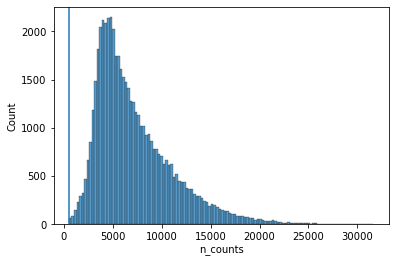

In [16]:
sns.histplot(adata.obs['n_counts'])
plt.axvline(500)

Looks like cells with less than 500 counts were removed, that's good enough.

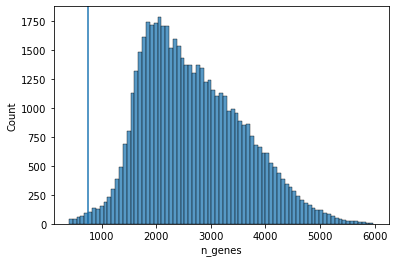

In [17]:
sns.histplot(adata.obs['n_genes'])
plt.axvline(750)

No apparent filtering here, we will remove cells with less than 750 genes.

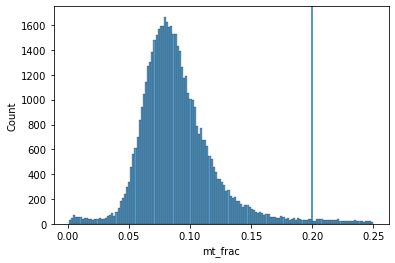

In [18]:
sns.histplot(adata.obs['mt_frac'])
plt.axvline(0.2)

Also here no filtering, we will remove cells with mt-frac > 0.2.

In [19]:
adata = adata[adata.obs['n_genes'] > 750]
adata = adata[adata.obs['mt_frac'] < 0.2]
adata

View of AnnData object with n_obs × n_vars = 51989 × 17344
    obs: 'barcode', 'nCount_RNA', 'cluster_name', 'celltype', 'donor', 'stim', 'totally_qualified', 'unabiguous_sgRNA', 'sgRNA', 'ntc', 'target', 'stim_celltype', 'n_counts', 'n_genes', 'mt_frac'
    var: 'ENSGNM', 'name', 'is_sgRNA', 'mito'

<AxesSubplot:xlabel='n_counts', ylabel='n_genes'>

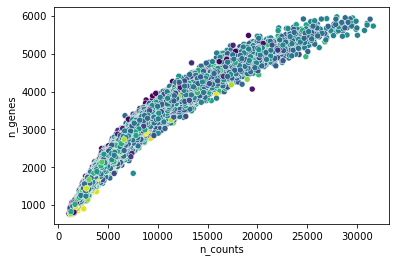

In [20]:
sns.scatterplot(
    adata.obs['n_counts'],
    adata.obs['n_genes'],
    c=adata.obs['mt_frac']
)

## Normalization
CPA and other downstream analyses require normalized log1p transformed counts.

In [21]:
sc.pp.normalize_total(adata)
#adata.layers['counts'] = adata.X.copy()
sc.pp.log1p(adata)

In [22]:
np.max(adata.X[0,:].toarray())

5.114424

## Feature (gene) selection
We select only the top N most variable genes.

In [23]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='cell_ranger')

In [24]:
gene_targeted = [n in adata.obs['target'].cat.categories for n in adata.var['name']]
adata = adata[:, [a or b for a, b in zip(gene_targeted, adata.var.highly_variable)]]

In [25]:
adata

View of AnnData object with n_obs × n_vars = 51989 × 2013
    obs: 'barcode', 'nCount_RNA', 'cluster_name', 'celltype', 'donor', 'stim', 'totally_qualified', 'unabiguous_sgRNA', 'sgRNA', 'ntc', 'target', 'stim_celltype', 'n_counts', 'n_genes', 'mt_frac'
    var: 'ENSGNM', 'name', 'is_sgRNA', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## EDA

In [26]:
adata.obs

,barcode,nCount_RNA,cluster_name,celltype,donor,stim,totally_qualified,unabiguous_sgRNA,sgRNA,ntc,target,stim_celltype,n_counts,n_genes,mt_frac
0,AAACCCACAACAAGAT-1,3650.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,PLCG2-2,False,PLCG2,resting_cd8,3650.0,1825,0.108767
3,AAACCCACACCCTGTT-1,9719.0,10: Proliferating (S,CD4,Donor1,Resting,True,True,OTUD7B-1,False,OTUD7B,resting_cd4,9717.0,3437,0.065349
4,AAACCCACACTATGTG-1,4043.0,6: CD4 Common,Unassigned,Donor2,Resting,False,True,CD247-1,False,CD247,resting_unassigned,4039.0,1790,0.073285
6,AAACCCAGTATGAGAT-1,3222.0,6: CD4 Common,Unassigned,Donor1,Resting,False,True,IL2RB-2,False,IL2RB,resting_unassigned,3222.0,1390,0.108628
9,AAACCCATCTACCTTA-1,4602.0,8: CD8 Common,CD8,Donor2,Resting,True,True,PLCG2-2,False,PLCG2,resting_cd8,4602.0,2193,0.063885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103796,TTTGTTGCACAGCCAC-8,11612.0,14: CD4 Common,Unassigned,Donor2,Re-stimulated,False,True,TNFRSF12A-2,False,TNFRSF12A,restimulated_unassigned,11610.0,3753,0.058226
103797,TTTGTTGCACTATGTG-8,4278.0,14: CD4 Common,CD4,Donor1,Re-stimulated,True,True,LHX6-2,False,LHX6,restimulated_cd4,4275.0,2037,0.127485
103798,TTTGTTGCACTCAGAT-8,4369.0,1: IFNG High 1,Unassigned,Donor1,Re-stimulated,False,True,TBX21-2,False,TBX21,restimulated_unassigned,4366.0,2138,0.147503
103799,TTTGTTGCAGTCAGTT-8,2824.0,7: TNF Locus High,Unassigned,Donor1,Re-stimulated,False,True,TRIM21-2,False,TRIM21,restimulated_unassigned,2824.0,1445,0.189093


In [27]:
adata.obs.groupby('celltype').size() #how many cells have unassigned type

celltype
CD4           15772
CD8           23844
Unassigned    12373
dtype: int64

In [28]:
group_size = adata.obs.groupby('cluster_name').size()
col = group_size.index[np.argmin(group_size)]

adata.obs[(adata.obs['cluster_name']==col).to_numpy() & (adata.obs['ntc']==True).to_numpy()] #how many cells in control group are in the smallest cluster

,barcode,nCount_RNA,cluster_name,celltype,donor,stim,totally_qualified,unabiguous_sgRNA,sgRNA,ntc,target,stim_celltype,n_counts,n_genes,mt_frac
21357,GCCATGGAGCGTCTCG-2,5210.0,11: SERPINB1 High /,CD8,Donor1,Resting,True,True,NO-TARGET-5,True,NTC,resting_cd8,5208.0,2215,0.075269


In [29]:
target_size = adata.obs.groupby('target').size() #these are the perturbations (KOs)
col = target_size.index[np.argmin(target_size)]

adata.obs[(adata.obs['target']==col).to_numpy() & (adata.obs['ntc']==False).to_numpy()]

,barcode,nCount_RNA,cluster_name,celltype,donor,stim,totally_qualified,unabiguous_sgRNA,sgRNA,ntc,target,stim_celltype,n_counts,n_genes,mt_frac
316,AACGTCAAGCATCAGG-1,13302.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,LHX4-2,False,LHX4,resting_cd8,13284.0,4159,0.071213
393,AAGATAGGTCTAATCG-1,8990.0,13: Proliferating (G,CD4,Donor2,Resting,True,True,LHX4-1,False,LHX4,resting_cd4,8987.0,3250,0.087905
405,AAGCATCGTTCCAGGC-1,4163.0,4: TCR High,CD4,Donor2,Resting,True,True,LHX4-1,False,LHX4,resting_cd4,4162.0,1777,0.066795
1006,ACCTACCCATGAGTAA-1,6739.0,6: CD4 Common,CD4,Donor2,Resting,True,True,LHX4-1,False,LHX4,resting_cd4,6736.0,2415,0.101395
1557,AGACCATCACCAGTAT-1,12423.0,10: Proliferating (S,Unassigned,Donor2,Resting,False,True,LHX4-1,False,LHX4,resting_unassigned,12419.0,3822,0.092600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101467,TCCGAAAAGAGCCCAA-8,10299.0,14: CD4 Common,CD4,Donor2,Re-stimulated,True,True,LHX4-2,False,LHX4,restimulated_cd4,10298.0,3521,0.063702
101571,TCCTTCTGTCAGCGTC-8,6809.0,14: CD4 Common,CD4,Donor1,Re-stimulated,True,True,LHX4-2,False,LHX4,restimulated_cd4,6805.0,2858,0.094636
101717,TCGGGCAAGCATGCGA-8,15208.0,5: Proliferative (S),CD4,Donor1,Re-stimulated,True,True,LHX4-1,False,LHX4,restimulated_cd4,15207.0,4398,0.074439
102449,TGCTTGCGTCTCACAA-8,10573.0,14: CD4 Common,CD4,Donor1,Re-stimulated,True,True,LHX4-1,False,LHX4,restimulated_cd4,10570.0,3486,0.084579


<AxesSubplot:ylabel='Count'>

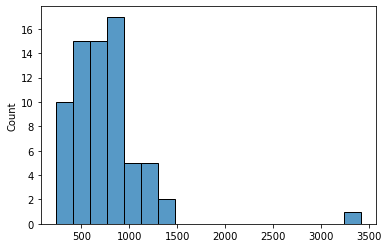

In [30]:
sns.histplot(target_size)

In [31]:
np.min(target_size)

236

In [32]:
adata.obs.groupby('stim_celltype').size() #these are the celltypes

stim_celltype
restimulated_cd4            8185
restimulated_cd8           11461
restimulated_unassigned     6364
resting_cd4                 7587
resting_cd8                12383
resting_unassigned          6009
dtype: int64

In [33]:
#remove unassigned donor cell and unassigned celltype
adata = adata[adata.obs['donor'].str.contains('Donor')]
adata = adata[adata.obs['celltype'].str.contains('CD4|CD8')]
adata = adata[adata.obs['stim_celltype'].str.contains('cd4|cd8')]

In [34]:
adata.obs

,barcode,nCount_RNA,cluster_name,celltype,donor,stim,totally_qualified,unabiguous_sgRNA,sgRNA,ntc,target,stim_celltype,n_counts,n_genes,mt_frac
0,AAACCCACAACAAGAT-1,3650.0,13: Proliferating (G,CD8,Donor1,Resting,True,True,PLCG2-2,False,PLCG2,resting_cd8,3650.0,1825,0.108767
3,AAACCCACACCCTGTT-1,9719.0,10: Proliferating (S,CD4,Donor1,Resting,True,True,OTUD7B-1,False,OTUD7B,resting_cd4,9717.0,3437,0.065349
9,AAACCCATCTACCTTA-1,4602.0,8: CD8 Common,CD8,Donor2,Resting,True,True,PLCG2-2,False,PLCG2,resting_cd8,4602.0,2193,0.063885
12,AAACGAAAGCATGCAG-1,4775.0,4: TCR High,CD8,Donor2,Resting,True,True,APOBEC3D-2,False,APOBEC3D,resting_cd8,4774.0,2295,0.119606
16,AAACGAAAGTGGACTG-1,8209.0,16: FOXL2NB Guides,CD4,Donor2,Resting,True,True,FOXL2NB-2,False,FOXL2NB,resting_cd4,8202.0,3065,0.110339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103791,TTTGGTTTCTAGCCTC-8,15641.0,1: IFNG High 1,CD8,Donor2,Re-stimulated,True,True,VAV1-2,False,VAV1,restimulated_cd8,15640.0,4476,0.070077
103793,TTTGTTGAGGACGGAG-8,6604.0,10: CD8 Common,CD8,Donor1,Re-stimulated,True,True,BICDL2-1,False,BICDL2,restimulated_cd8,6598.0,2732,0.174901
103794,TTTGTTGAGGTATTGA-8,4672.0,10: CD8 Common,CD8,Donor2,Re-stimulated,True,True,PIK3AP1-1,False,PIK3AP1,restimulated_cd8,4672.0,2123,0.097389
103797,TTTGTTGCACTATGTG-8,4278.0,14: CD4 Common,CD4,Donor1,Re-stimulated,True,True,LHX6-2,False,LHX6,restimulated_cd4,4275.0,2037,0.127485


## Visualization

In [35]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

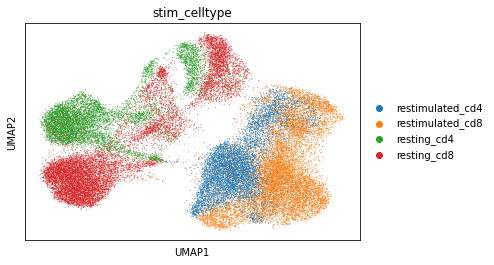

In [36]:
sc.pl.umap(adata, color='stim_celltype')

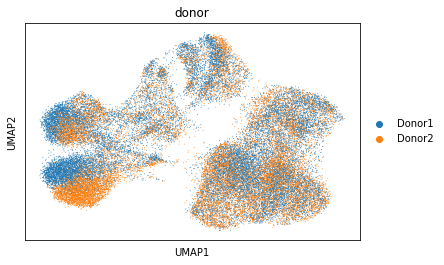

In [37]:
sc.pl.umap(adata, color='donor')

In [38]:
results = []
for cond1 in adata.obs.target.unique():
    ad1 = adata[adata.obs.target == cond1]
    ad2 = adata[adata.obs.target != cond1]
    mean1 = ad1.X.mean(0)
    mean2 = ad2.X.mean(0)
    l2 = np.linalg.norm(mean1-mean2)
    results.append({
        'cond1': cond1,       
        'L2': l2
    })
df_vs_rest = pd.DataFrame(results)

Let's pick biggest signals

In [39]:
df_vs_rest.sort_values(by='L2').tail(20)

,cond1,L2
64,ITPKA,2.844133
2,APOBEC3D,2.854781
32,APOBEC3C,2.907403
60,LAT2,2.941981
65,FOXD2,2.946915
69,INPPL1,2.954060
37,SLA2,2.979501
55,LHX4,3.012738
56,AKAP12,3.144403
54,GATA3,3.281240


In [40]:
KO_OOD = df_vs_rest.sort_values(by='L2').tail(20).cond1.values
KO_OOD

array(['ITPKA', 'APOBEC3D', 'APOBEC3C', 'LAT2', 'FOXD2', 'INPPL1', 'SLA2',
       'LHX4', 'AKAP12', 'GATA3', 'CD247', 'MAP4K1', 'CD27', 'TNFRSF1A',
       'MUC1', 'TBX21', 'TNFRSF1B', 'LTBR', 'EOMES', 'FOXL2NB'],
      dtype=object)

In [41]:
results = []
for cond1 in adata.obs.target.unique():
    for cond2 in adata.obs.target.unique():
        ad1 = adata[adata.obs.target == cond1]
        ad2 = adata[adata.obs.target == cond2]
        mean1 = ad1.X.mean(0)
        mean2 = ad2.X.mean(0)
        l2 = np.linalg.norm(mean1-mean2)
        results.append({
            'cond1': cond1,       
            'cond2': cond2,
            'L2': l2
        })

In [42]:
df = pd.DataFrame(results)
df = pd.pivot_table(index='cond1', columns='cond2', data=df)

<AxesSubplot:xlabel='None-cond2', ylabel='cond1'>

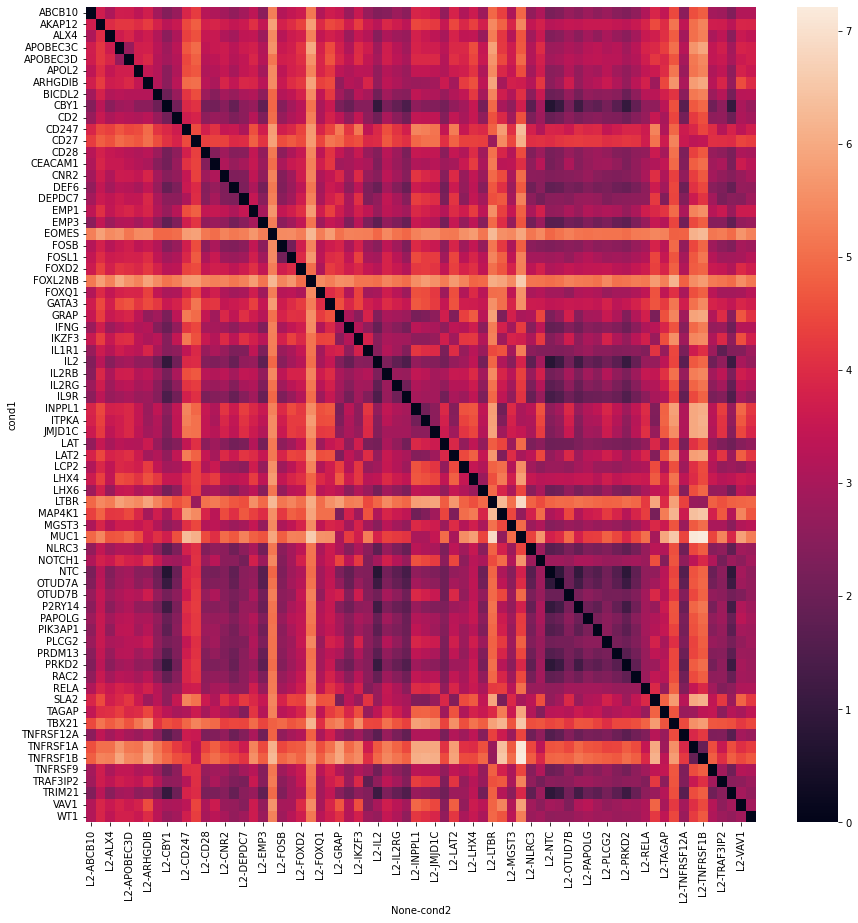

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(df, ax=ax)

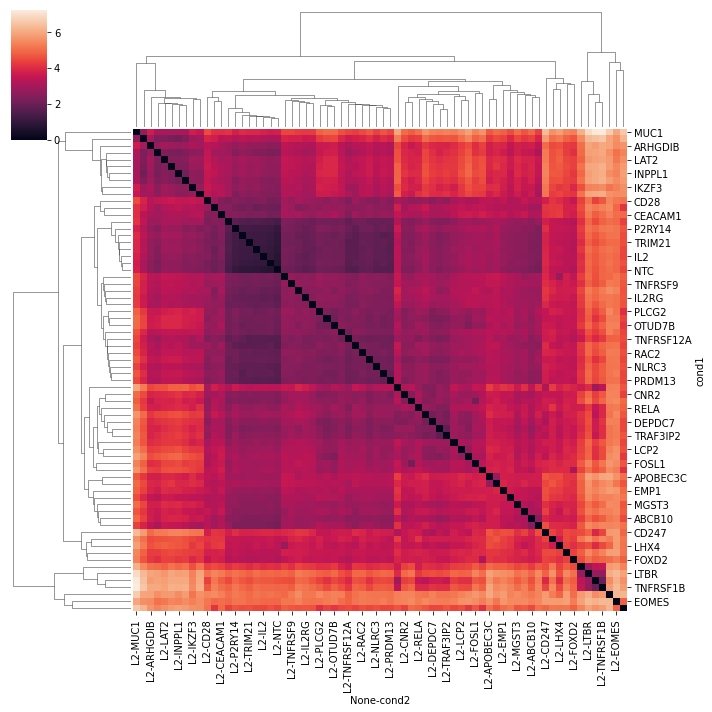

In [44]:
sns.clustermap(df)

## Prepare for the model

In [45]:
adata.obs['perturbation'] = adata.obs['target'].copy()

In [46]:
adata.obs['control'] = [1 if x == 'NTC' else 0 for x in adata.obs['perturbation'].values]

In [47]:
adata.obs['dose'] = [s.split('-')[-1] for s in adata.obs['sgRNA']]

In [48]:
del adata.obs['nCount_RNA']
del adata.uns['log1p']

In [49]:
adata.obs['split'] = 'NA'

adata.obs['split'][
    (adata.obs['stim_celltype'] == 'restimulated_cd8')
    & (adata.obs['target'].isin(KO_OOD))
] = 'ood'

idx = np.where(adata.obs['split']=='NA')[0]
idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=42)

adata.obs['split'].iloc[idx_train] = 'train'
adata.obs['split'].iloc[idx_test] = 'test'

Rank DE genes

In [50]:
cov_names = []
for cov in ['celltype', 'donor', 'stim']:
    cov_names.append(np.array(adata.obs[cov].values))
cov_names = ["_".join(c) for c in zip(*cov_names)]
adata.obs["cov_name"] = cov_names

In [51]:
cov_pert_names = []
for i in range(len(adata)):
    comb_name = (
        f"{adata.obs['cov_name'].values[i]}"
        f"_{adata.obs['target'].values[i]}"
    )
    cov_pert_names.append(comb_name)
adata.obs["cov_pert_name"] = cov_pert_names

In [52]:
rank_genes_groups(adata,
    groupby="cov_pert_name",
    reference="cov_name",
    control_key="control"
)

In [53]:
adata.obs

,barcode,cluster_name,celltype,donor,stim,totally_qualified,unabiguous_sgRNA,sgRNA,ntc,target,stim_celltype,n_counts,n_genes,mt_frac,perturbation,control,dose,split,cov_name,cov_pert_name
0,AAACCCACAACAAGAT-1,13: Proliferating (G,CD8,Donor1,Resting,True,True,PLCG2-2,False,PLCG2,resting_cd8,3650.0,1825,0.108767,PLCG2,0,2,train,CD8_Donor1_Resting,CD8_Donor1_Resting_PLCG2
3,AAACCCACACCCTGTT-1,10: Proliferating (S,CD4,Donor1,Resting,True,True,OTUD7B-1,False,OTUD7B,resting_cd4,9717.0,3437,0.065349,OTUD7B,0,1,train,CD4_Donor1_Resting,CD4_Donor1_Resting_OTUD7B
9,AAACCCATCTACCTTA-1,8: CD8 Common,CD8,Donor2,Resting,True,True,PLCG2-2,False,PLCG2,resting_cd8,4602.0,2193,0.063885,PLCG2,0,2,train,CD8_Donor2_Resting,CD8_Donor2_Resting_PLCG2
12,AAACGAAAGCATGCAG-1,4: TCR High,CD8,Donor2,Resting,True,True,APOBEC3D-2,False,APOBEC3D,resting_cd8,4774.0,2295,0.119606,APOBEC3D,0,2,train,CD8_Donor2_Resting,CD8_Donor2_Resting_APOBEC3D
16,AAACGAAAGTGGACTG-1,16: FOXL2NB Guides,CD4,Donor2,Resting,True,True,FOXL2NB-2,False,FOXL2NB,resting_cd4,8202.0,3065,0.110339,FOXL2NB,0,2,test,CD4_Donor2_Resting,CD4_Donor2_Resting_FOXL2NB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103791,TTTGGTTTCTAGCCTC-8,1: IFNG High 1,CD8,Donor2,Re-stimulated,True,True,VAV1-2,False,VAV1,restimulated_cd8,15640.0,4476,0.070077,VAV1,0,2,train,CD8_Donor2_Re-stimulated,CD8_Donor2_Re-stimulated_VAV1
103793,TTTGTTGAGGACGGAG-8,10: CD8 Common,CD8,Donor1,Re-stimulated,True,True,BICDL2-1,False,BICDL2,restimulated_cd8,6598.0,2732,0.174901,BICDL2,0,1,train,CD8_Donor1_Re-stimulated,CD8_Donor1_Re-stimulated_BICDL2
103794,TTTGTTGAGGTATTGA-8,10: CD8 Common,CD8,Donor2,Re-stimulated,True,True,PIK3AP1-1,False,PIK3AP1,restimulated_cd8,4672.0,2123,0.097389,PIK3AP1,0,1,train,CD8_Donor2_Re-stimulated,CD8_Donor2_Re-stimulated_PIK3AP1
103797,TTTGTTGCACTATGTG-8,14: CD4 Common,CD4,Donor1,Re-stimulated,True,True,LHX6-2,False,LHX6,restimulated_cd4,4275.0,2037,0.127485,LHX6,0,2,train,CD4_Donor1_Re-stimulated,CD4_Donor1_Re-stimulated_LHX6


In [54]:
adata

AnnData object with n_obs × n_vars = 39616 × 2013
    obs: 'barcode', 'cluster_name', 'celltype', 'donor', 'stim', 'totally_qualified', 'unabiguous_sgRNA', 'sgRNA', 'ntc', 'target', 'stim_celltype', 'n_counts', 'n_genes', 'mt_frac', 'perturbation', 'control', 'dose', 'split', 'cov_name', 'cov_pert_name'
    var: 'ENSGNM', 'name', 'is_sgRNA', 'mito', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'stim_celltype_colors', 'donor_colors', 'rank_genes_groups_cov'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [55]:
adata.write('marson_prepped.h5ad')

In [56]:
'NTC' in adata.obs.target.unique()

True